In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
os.listdir('/kaggle/input/animefacedataset/')

['images']

In [3]:
root = '/kaggle/input/animefacedataset/images/'

In [4]:
import torch, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import cv2
from PIL import Image

In [29]:
image_size = 200
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [30]:
img = cv2.imread(root+'1947_2001.jpg')

In [31]:
img.shape

(41, 41, 3)

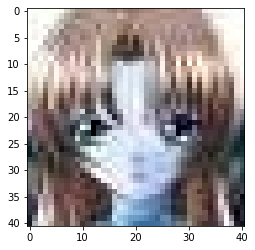

In [32]:
plt.imshow(img)

In [33]:
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])

In [34]:
os.listdir(root)[9]

'5148_2003.jpg'

In [35]:
class AnimeData(Dataset):
    
    def __init__(self, root, transform=None):
        
        self.path = root
        self.transform = transform
        self.images = os.listdir(self.path)
        
    def __len__(self):
        return len(os.listdir(self.path))
    
    
    def __getitem__(self, index):
        
        img = Image.open(self.path+self.images[index])
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img

In [36]:
trainset = AnimeData(root,transform)

In [37]:
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [38]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [39]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

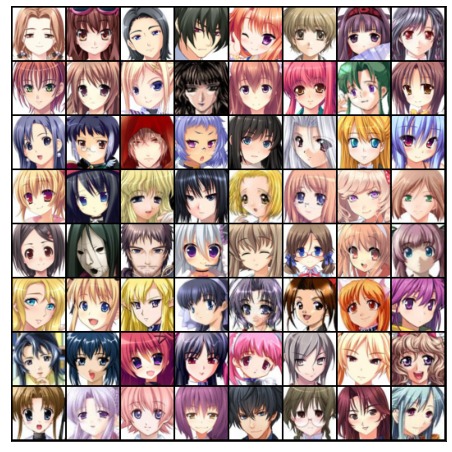

In [40]:
show_batch(trainloader)

In [41]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
trainloader = DeviceDataLoader(trainloader, device)

## Discriminator

In [74]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [60]:
discriminator = to_device(discriminator, device)

## Generator

In [61]:
latent_size = 128

In [62]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


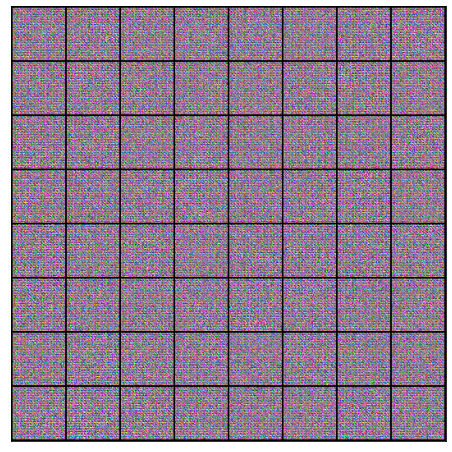

In [63]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [64]:
generator = to_device(generator, device)

In [65]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    #print(real_targets.shape)
    #print(real_preds.shape)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    #print(fake_images.shape)
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    #print(fake_targets.shape)
    #print(fake_preds.shape)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [66]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)   # The label is set to 1(real-like) to fool the discriminator
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [67]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [68]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()

In [69]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


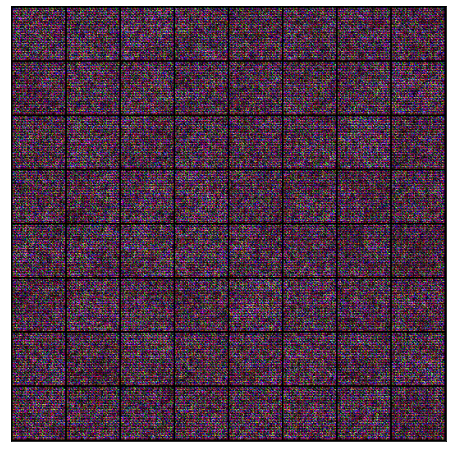

In [70]:
save_samples(0, fixed_latent)

In [71]:
lr = 0.0002
epochs = 40

In [72]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))


Epoch [1/40], loss_g: 5.8180, loss_d: 0.0074, real_score: 0.9986, fake_score: 0.0059
Saving generated-images-0001.png


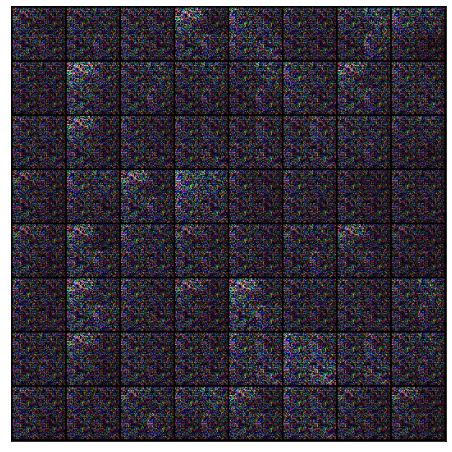


Epoch [2/40], loss_g: 6.5213, loss_d: 0.0023, real_score: 0.9999, fake_score: 0.0022
Saving generated-images-0002.png


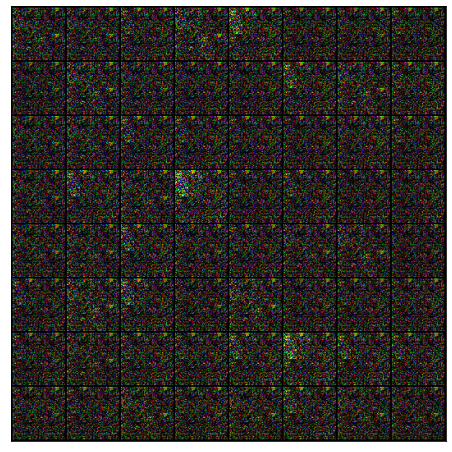


Epoch [3/40], loss_g: 7.8864, loss_d: 0.0006, real_score: 0.9998, fake_score: 0.0005
Saving generated-images-0003.png


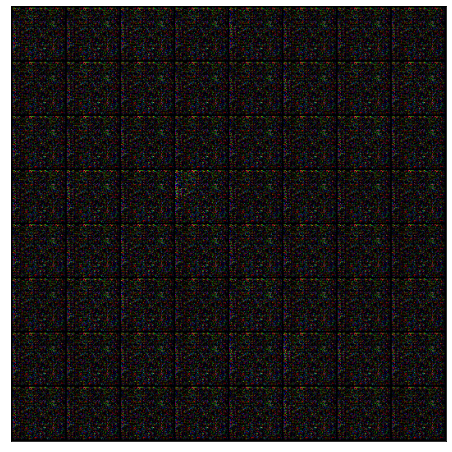


Epoch [4/40], loss_g: 5.7547, loss_d: 0.0324, real_score: 0.9913, fake_score: 0.0231
Saving generated-images-0004.png


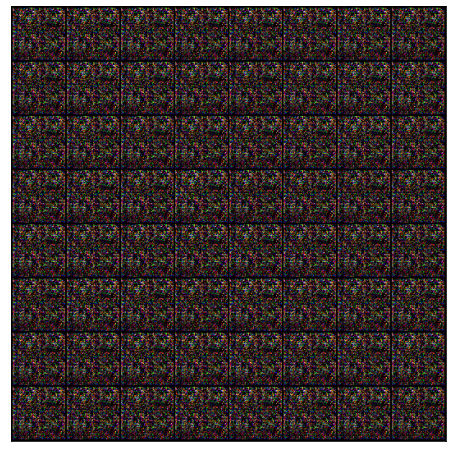


Epoch [5/40], loss_g: 5.6777, loss_d: 0.0162, real_score: 0.9882, fake_score: 0.0036
Saving generated-images-0005.png


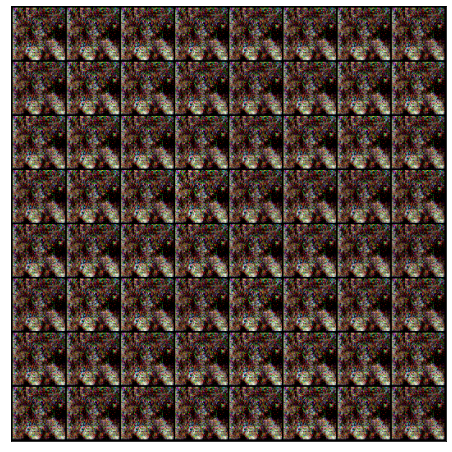


Epoch [6/40], loss_g: 5.5942, loss_d: 0.0160, real_score: 0.9919, fake_score: 0.0040
Saving generated-images-0006.png


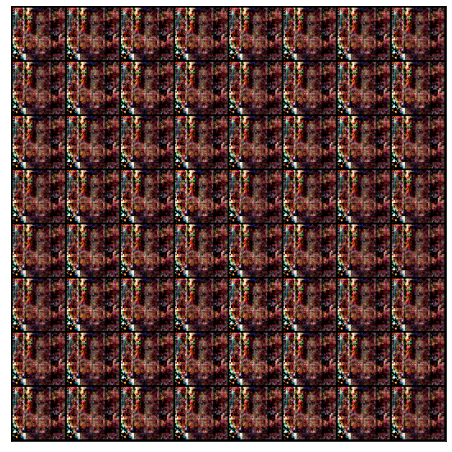


Epoch [7/40], loss_g: 6.0497, loss_d: 0.0054, real_score: 0.9975, fake_score: 0.0029
Saving generated-images-0007.png


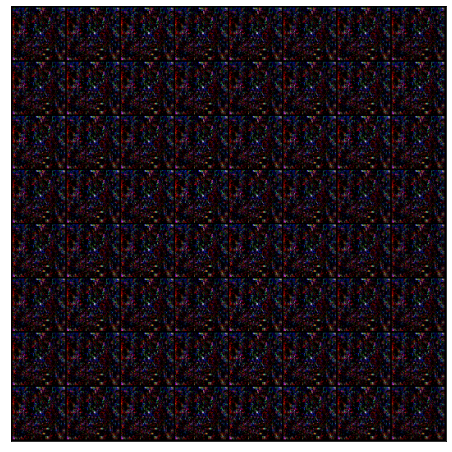


Epoch [8/40], loss_g: 6.3739, loss_d: 0.0024, real_score: 0.9997, fake_score: 0.0021
Saving generated-images-0008.png


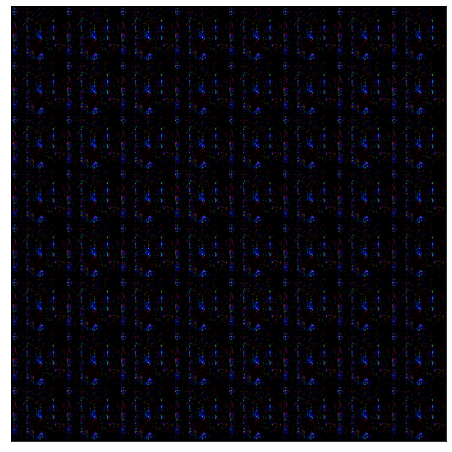


Epoch [9/40], loss_g: 7.5780, loss_d: 0.0020, real_score: 0.9986, fake_score: 0.0005
Saving generated-images-0009.png


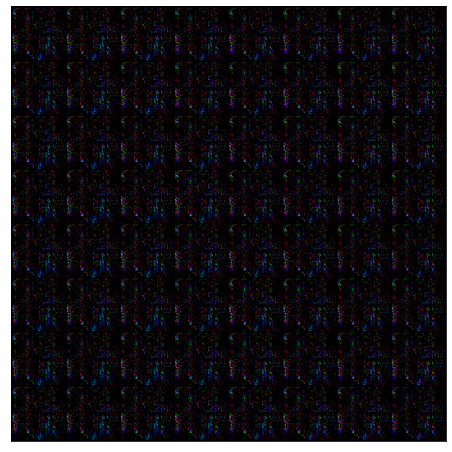

KeyboardInterrupt: 

In [73]:
torch.cuda.empty_cache()
start_idx=1
# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []


for epoch in range(epochs):
    for real_images in tqdm(trainloader):
        # Train discriminator
        loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
        # Train generator
        loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=True)

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()